<img style='float: right' src="http://cer.ucsd.edu/_images/logo-bw.jpg" width="200" height="40" > <br> <br>
# Cine Pre-Process
## Fast Camera Raw Data Pre-Processing Notebook


### Description:
Converts .cine file to .h5 file. Performs DC background subtraction and saves DC-Offset data.

Version 1.0, 6-OCT-2016

In [1]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

import sys, traceback, struct, tables, h5py, sys
import math as m
from tqdm import tqdm
from __future__ import print_function
import numpy as np
from PyQt4 import QtGui

In [2]:
def openfile_dialog():
    from PyQt4 import QtGui
    app = QtGui.QApplication([dir])
    fname = QtGui.QFileDialog.getOpenFileName(None, "Select a file...",'..\\..\\2  Data\\1  Fast Camera Data\\', filter="All files (*.cine)")
    return str(fname)

#  Open .cine File to Convert

In [3]:
filename = openfile_dialog()

In [21]:
class Cine(object):
	def __init__(self,filename,framelims,**kwargs):
		with open(filename,"rb") as cinefile:
			filetype = struct.unpack('<2s',cinefile.read(2))[0]
			cinefile.seek(0) #return to top of file for reading
			assert filetype == 'CI', \
			    "File is not standard .cine format or file is corrupt."
			self._read_cine(cinefile,framelimits=framelims,**kwargs)


            
            
	def _read_cine(self,cinefile,no_tagged_blocks=False,
		       no_attributes=False,read_images=True,
		       framelimits=None):
		# first 44 bytes are file header
		header_length = 44
		self.CineFileHeader = self._get_CineFileHeader(cinefile.read(header_length))
		# if framelimits undefined, set to entire sequence
		if framelimits is None:
			framelimits = [0,self.CineFileHeader['ImageCount']]
		bitmapinfo_length = 40
		self.BitmapInfoHeader = self._get_BitmapInfoHeader(cinefile.read(bitmapinfo_length))
		deprecated_skip = 140  
		cinefile.seek(header_length+bitmapinfo_length+deprecated_skip)  
		# check that setup is at correct Mark location
		setupstring = struct.unpack("<2s",cinefile.read(2))[0]
		if not (setupstring == 'ST'):
			print(setupstring)
			print("SETUP structure marker is incorrect.")
			print("File format may have changed or file may be damaged.")
		# get the length of the entire Setup structure
		setup_length = struct.unpack("<H",cinefile.read(2))[0]
		setup_initial_skip = 597 
		new_setup_start_position = (header_length + bitmapinfo_length+ deprecated_skip+setup_initial_skip)
		cinefile.seek(new_setup_start_position)
		setup_zeros_length = 1212
		setup_read_length = (setup_length - setup_initial_skip - setup_zeros_length - deprecated_skip)
		self.Setup = self._get_Setup(cinefile.read(setup_read_length))
		cinefile.seek(header_length+bitmapinfo_length+setup_length)
		if no_tagged_blocks:
			self.TaggedBlocks = {}
		else:
			tag_start = setup_length+header_length+bitmapinfo_length
			self.TaggedBlocks = self._get_TaggedBlocks(cinefile,tag_start,framelimits)     
		if read_images:
			self.images = self._get_Images(cinefile,self.CineFileHeader["OffImageOffsets"],framelimits)
		self.framelimits=framelimits

		if no_attributes:
			return
		else:
			# Define object attributes corresponding to each dictionary entry
			# (for convenience) 
			for key,value in self.CineFileHeader.iteritems():
				setattr(self,key,value)
			for key,value in self.BitmapInfoHeader.iteritems():
				setattr(self,key,value)
			for key,value in self.Setup.iteritems():
				setattr(self,key,value)
			for key,value in self.TaggedBlocks.iteritems():
				setattr(self,key,value)
			return
		

	def _get_CineFileHeader(self,filestring):
		# entire filestring is 44 bytes long, with 12 variables (13 values)
		filetuple = struct.unpack('<2s 3H l I l 6I',filestring)
		header_dict = {}
		# assign dictionary key/value pairs and class attributes exactly
		# as laid out in cine640.pdf
		header_dict["Type"] = filetuple[0]
		header_dict["Headersize"] = filetuple[1]
		header_dict["Compression"] = filetuple[2]
		header_dict["Version"] = filetuple[3]
		header_dict["FirstMovieImage"] = filetuple[4]
		header_dict["TotalImageCount"] = filetuple[5]
		header_dict["FirstImageNo"] = filetuple[6]
		header_dict["ImageCount"] = filetuple[7]
		header_dict["OffImageHeader"] = filetuple[8]
		header_dict["OffSetup"] = filetuple[9]
		header_dict["OffImageOffsets"] = filetuple[10]
		header_dict["TriggerTime"] = (filetuple[11],filetuple[12])
		return header_dict

	def _get_BitmapInfoHeader(self,filestring):
		# entire filestring is 40 bytes long, with 11 variables
		filetuple = struct.unpack('<I 2l 2H 2I 2l 2I',filestring)
		bitmap_dict = {}
		# assign dictionary key/value pairs and class attributes exactly
		# as laid out in cine640.pdf
		bitmap_dict["biSize"] = filetuple[0]
		bitmap_dict["biWidth"] = filetuple[1]
		bitmap_dict["biHeight"] = filetuple[2]
		bitmap_dict["biPlanes"] = filetuple[3]
		bitmap_dict["biBitCount"] = filetuple[4] 
		# note that this may be different from Setup.RealBPP
		# Pixels are stored only at 8 bits or 16 bits
		#     even if they are recorded at different depth
		bitmap_dict["biCompression"] = filetuple[5]
		bitmap_dict["biSizeImage"] = filetuple[6]
		bitmap_dict["biXPelsPerMeter"] = filetuple[7]
		bitmap_dict["biYPelsPerMeter"] = filetuple[8]
		bitmap_dict["biClrUsed"] = filetuple[9]
		bitmap_dict["biClrImportant"] = filetuple[10]
		return bitmap_dict
		
	def _get_Setup(self,filestring):
		format_ImWidth_RealBPP_inclusive ="2H H I l B I ???? ????  I I 2I I I" + "???? 3I l I 3l 3I 4I 8f l 2f I" 
		# the next chunk is skipped stuff
		format_Conv8min_MCPercent_inclusive = "2I 30l 3I 4? 2I 16l 32I l 64f" 
		format_CICalib_Description_end_inclusive = "7I 8I 4I 4I 4096s"
		format_string = ("<" + format_ImWidth_RealBPP_inclusive + format_Conv8min_MCPercent_inclusive + format_CICalib_Description_end_inclusive)
		filetuple = struct.unpack(format_string,filestring)
		setup_dict = {}

		setup_dict["ImWidth"] = filetuple[0]
		setup_dict["ImHeight"] = filetuple[1]
		# skip filetuple[2] = EDRShutter16
		setup_dict["Serial"] = filetuple[3]
		# skip filetuple[4:15] = saturation, autoexposure, and PCC setup vars
		setup_dict["FrameRate"] = filetuple[16]
		# skip [17:18] - deprecated shutter vars
		setup_dict["PostTrigger"] = filetuple[19]
		# skip [20:24], deprecated and color vars
		setup_dict["CameraVersion"] = filetuple[25]
		setup_dict["FirmwareVersion"] = filetuple[26]
		setup_dict["SoftwareVersion"] = filetuple[27]
		# skip [28:50] - timezone and PCC setup vars 
		setup_dict["RealBPP"] = filetuple[51]

		setup_dict["CICalib"] = filetuple[206]
		setup_dict["CalibWidth"] = filetuple[207]
		setup_dict["CalibHeight"] = filetuple[208]
		setup_dict["CalibRate"] = filetuple[209]
		setup_dict["CalibExp"] = filetuple[210]
		setup_dict["CalibEDR"] = filetuple[211]
		setup_dict["CalibTemp"] = filetuple[212]
		# skip [213:220] - unused options        
		setup_dict["Sensor"] = filetuple[221]
		setup_dict["ShutterNs"] = filetuple[222]
		setup_dict["EDRShutterNs"] = filetuple[223]
		setup_dict["FrameDelayNs"] = filetuple[224]
		# skip [225:228] - sidestamped image offsets
		# strip trailing zeros from description and encode
		desc_string = filetuple[229].rstrip('\x00')
		return setup_dict

	def _get_TaggedBlocks(self,cinefile,tag_start,framelims):		
	    # store tagged blocks as a dictionary since we don't 
	    # know how many blocks or how big they are
		blocks_dict = {}
		tag_type_dict = {1002:'TimeOnly',1003:'ExposureOnly',1004:'RangeData',1005:'BinSig',1006:'AnaSig'}
		
		# Construct dictionary of block types with how many bytes each 
		#     data value takes
		# USAGE NOT YET IMPLEMENTED
		tag_data_size_dict = {1002:'8',1003:'4',1004:'1',1005:'1',1006:'2'}
		tagged_length = 0
		# Keep list of tag header information for each block
		tag_headers = []  # for debugging
		# Move to beginning of tagged block section
		cinefile.seek(tag_start)
	    # Read in any tagged blocks until reaching the image data
		while (tagged_length + tag_start <= self.CineFileHeader["OffImageOffsets"]-1):  
			# header is always 8 bytes     
			tag_header = struct.unpack("< I H H",cinefile.read(8))  
			tag_headers.append(tag_header)
			BlockSize = tag_header[0]  #size is first DWORD
			data_length = BlockSize - 8  #again, header is always 8 bytes
			BlockType = tag_header[1]  #type is first WORD
			# "Reserved" is second WORD; is 0 in last block, 1 otherwise
			blocks_left = tag_header[2] 
			assert BlockType in tag_type_dict, ("Unknown tagged block type: "+ str(BlockType))
			if BlockType == 1002:
				# Time only block, format = (seconds,fraction * 2**32)
				bytes_per_value = 8  #(32.32 bits)
				ntimes = data_length/bytes_per_value
				# full precision tuple of arrays
				TimeOnly = (np.ndarray(ntimes,int),np.ndarray(ntimes,int))  
				# lower precision floating point representation
				time_float = np.ndarray((ntimes),np.float) 
				
				for time_step in range(ntimes):
					# Read in Fraction field of Time64 structure
					fraction = struct.unpack("<I",cinefile.read(4))[0]
					# Read in Seconds field
					seconds = struct.unpack("<I",cinefile.read(4))[0]
					# Populate tuple
					TimeOnly[0][time_step] = seconds
					TimeOnly[1][time_step] = seconds
					time_float[time_step] = np.longdouble(seconds \
                                                             - self.CineFileHeader["TriggerTime"][1])\
                    + np.longdouble(fraction \
                                       - self.CineFileHeader["TriggerTime"][0])/(2**32)
				# Full representation
				blocks_dict["TimeOnly"] = zip(np.asarray(TimeOnly)[0,framelims[0]:framelims[1]],np.asarray(TimeOnly)[1,framelims[0]:framelims[1]])
				# Convenience floating point representation
				blocks_dict["time_float"] = time_float[framelims[0]:framelims[1]]
			if BlockType == 1003:
				# Exposure only block, format = fraction * 2**32)
				bytes_per_value = 4  #(0.32 bits)
				nexp = data_length/bytes_per_value
				# full precision integer array (32/64 bits depending on arch)
				ExposureOnly = np.ndarray(nexp, int) 
				# (possibly) lower precision floating point representation
				exposure_float = np.ndarray(nexp,np.float) 
				for time_step in range(nexp):
					# Read in exposure fraction integer
					fraction = struct.unpack("<I",cinefile.read(4))[0]
					# Populate integer array
					ExposureOnly[time_step] = fraction
					# Populate float array
					# Use 128-byte float to preserve precision during calc. 
					exposure_float[time_step] = (np.float(fraction)/ np.float(2**32))
				# Full representation
				blocks_dict["ExposureOnly"] = ExposureOnly[framelims[0]:framelims[1]]
				# Convenience floating point representation
				blocks_dict["exposure_float"] = exposure_float[framelims[0]:framelims[1]]
			
			# add size of current block to total length of tagged portion
			tagged_length += BlockSize

		# add list of tag headers to dictionary (for debugging)
		#blocks_dict["tag_headers"] = tag_headers

		return blocks_dict # outside while loop

	def _get_Images(self,cinefile,start_pos,framelims):       
		nx = self.Setup["ImWidth"]
		ny = self.Setup["ImHeight"]
		nframes = self.CineFileHeader["ImageCount"]
		pointer_array = np.ndarray((nframes),np.int64)
		# Read image pointer array (Q = unsigned int64)
		cinefile.seek(start_pos)  # make sure we are at image start position
		pointer_array = struct.unpack("<"+str(nframes)+"Q",cinefile.read(nframes*8))
		if framelims == None:
			framelims = (0,nframes)
		# Redefine nframes to actual number of frames to record
		nframes = framelims[1] - framelims[0]
		print('Reading %d Frames (double tap I to interrupt)' % (nframes))
		sys.stdout.flush()
		image_array = np.ndarray((ny,nx,nframes),float)
		for frame in tqdm(range(nframes)):
			AnnotationSize = struct.unpack('<I',cinefile.read(4))[0]
			string_size = AnnotationSize - 8
			Annotation, ImageSize = struct.unpack("<"+str(string_size)+"s I",cinefile.read(AnnotationSize-4))
			image_bits = struct.unpack("<"+str(ImageSize/2)+"H",cinefile.read(ImageSize))
			image_array[...,frame] = np.reshape(image_bits,(ny,nx))

		print("Read " + str(nframes) + " frames.")
		sys.stdout.flush()
		return image_array


	def save_hdf5(self,filepath="cine_file.h5"):
		print("Saving File in HDF5 format...")
		sys.stdout.flush()
		try:   
			f = tables.open_file(filepath,'w')    
		except IOError: 
			print("File already exists or unable to create file." ) 
			return 
		try:
			# try writing data, close file on fail
			# Write metadata variables
			attrGrp = f.create_group("/","Meta",
						title="Meta-data, including CineFileHeader, BitmapInfoHeader, and Setup variables.")
			f.create_array(attrGrp,"framelimits",self.framelimits)
			for key,value in self.BitmapInfoHeader.items():
				f.create_array(attrGrp,key,value)
			for key,value in self.CineFileHeader.items():
				f.create_array(attrGrp,key,value)
			for key,value in self.Setup.items():
				f.create_array(attrGrp,key,value)
			# If tagged blocks exists, make a group for them
			# and fill it with the datasets from TaggedBlocks
			if hasattr(self,"TaggedBlocks"):
				TBgrp = f.create_group("/","TaggedBlocks",title="Subgroup of all tagged blocks")
				for key,value in self.TaggedBlocks.items():
					f.create_array(TBgrp,key,value)
				# If time_float data exists, link to it from the root group
				if "time_float" in self.TaggedBlocks.keys():
					f.create_hard_link('/',"time_float","/TaggedBlocks/time_float")
			# Write image array into root group
			if hasattr(self,"images"):
				f.create_array(f.root,"images",self.images)
			f.close()
			print("Cine file saved succesfully in HDF5 format.")
		except:
			f.close()
			print(traceback.format_exc())
			print("Saving to h5 file has failed.")
			sys.stdout.flush()

def readframes(framelims):
	startframe = framelims[0]
	endframe = framelims[1]
	return [startframe, endframe]
            
def main(filename,framelims):
	print('Reading cine file ' + filename)
	sys.stdout.flush()
	if filename.endswith('.cine'):
		mov = Cine(filename,readframes(framelims))
		# Write into file with same name in same directory,
		# replacing '.cine' extension with '.h5'
		save_name = filename.rsplit('.cine',1)[0]+'.h5'
		mov.save_hdf5(filepath=save_name)
		return save_name
	else:
		print("File extension '%s' not recognized."%filename.rsplit('.',1)[1])
		print("Current version only converts raw '.cine' files.")
		return 0




In [31]:
h5path = main(filename,(0,3800))

Reading cine file L:/Master Drive/PISCES BIG/PISCES Share/2  Data/1  Fast Camera Data/2014_09_24/320A_2.5kW_3.2mt_650nm.cine
Reading 3800 Frames (double tap I to interrupt)


100%|████████████████████████████████████| 3800/3800 [00:02<00:00, 1406.89it/s]

Read 3800 frames.
Saving File in HDF5 format...
Cine file saved succesfully in HDF5 format.


In [32]:
with h5py.File(h5path,'r') as hf:
    print('List of arrays in this file: \n', hf.keys())
    hf_data = hf.get('images')
    data = np.array(hf_data)
    print('Shape of the Image Array: \n', data.shape)

List of arrays in this file: 
 [u'Meta', u'TaggedBlocks', u'images', u'time_float']
Shape of the Image Array: 
 (96L, 96L, 3800L)


# Plot Raw Data (Single Frame)

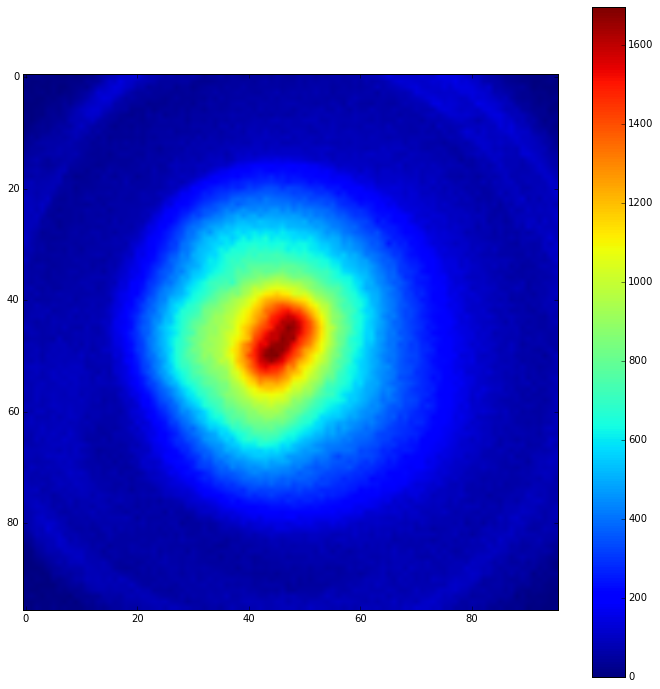

In [33]:
def cineplt(data):
    plt.figure(figsize = (12,12))
    img = data
    imgplot = plt.imshow(img)
    plt.colorbar()

cineplt(data[:,:,1])

In [34]:
I = len(data[:,1,1])
J = len(data[1,:,1])
K = len(data[1,1,:])

dc = np.zeros((I,J))

for i in tqdm(range(0,I)):
    for j in range(0,J):
        pixel = []
        for k in range(0,K):
            pixel.append(data[i,j,k])
        dc[i,j] = sum(pixel)/K

100%|██████████████████████████████████████████| 96/96 [00:14<00:00,  6.48it/s]


#  Background Subtraction
DC offset subtracts each pixel's mean value from every frame to expose the light intensity fluctuations.

<img style='float: center' src="http://images.books24x7.com/bookimages/id_32210/fig1-105.jpg"  > <br> <br>


In [35]:
dcoff = np.zeros((I,J,K))
for k in tqdm(range(0,K)):
    for i in range(0,I):
        for j in range(0,J):
               dcoff[i,j,k] = data[i,j,k] - dc[i,j]

100%|█████████████████████████████████████| 3800/3800 [00:26<00:00, 143.84it/s]


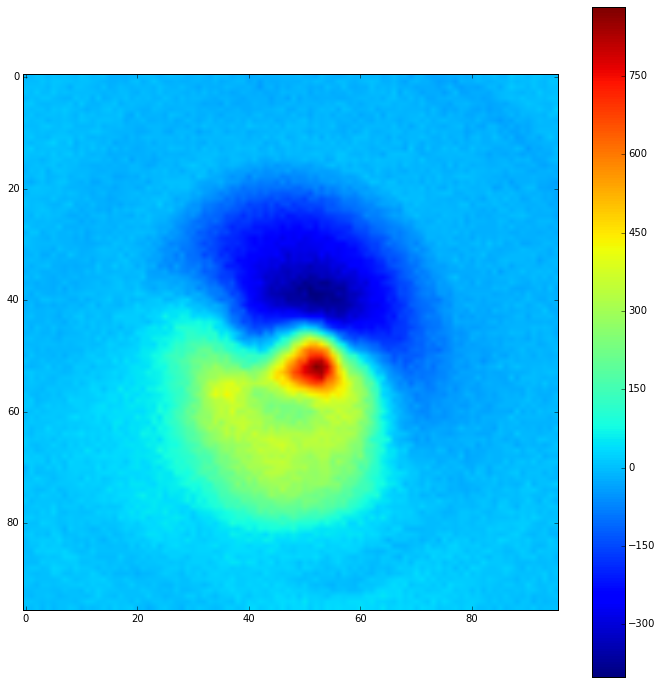

In [36]:
cineplt(dcoff[:,:,10])


# Export Processed Data (.h5)

In [37]:
dcpath = h5path.rsplit('.h5',1)[0]+'dcoff.h5'
with h5py.File(dcpath, 'w') as hf:
    hf.create_dataset('images', data=dcoff)

<footer>
  <p>Created by: Kyle Adriany</p>
  <p>Contact information: <a href="mailto:kyle.adriany@gmail.com">
    kyle.adriany@gmail.com</a>.</p>
    
    <p>Copyright © 2016 Kyle Adriany</p>
    
    <p>The MIT License (MIT)</p>
    

 <p>Permission is hereby granted, free of charge, to any person obtaining a copy
 of this software and associated documentation files (the "Software"), to deal
 in the Software without restriction, including without limitation the rights
 to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
 copies of the Software, and to permit persons to whom the Software is
 furnished to do so, subject to the following conditions:</p>
 
 <p>The above copyright notice and this permission notice shall be included in
all copies or substantial portions of the Software.</p>

 <p>THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
 IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
 FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
 AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
 LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
 OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
 THE SOFTWARE.</p>
</footer>